In [99]:
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import gudhi as gd
from persim.landscapes import (
    PersLandscapeExact,
    PersLandscapeApprox,
    plot_landscape,
    plot_landscape_simple
)
import persim as pm
from datetime import datetime, timedelta
import pytz
timezone =  pytz.FixedOffset(-240)

In [19]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

In [20]:
# Specify the path to your Parquet file
parquet_file_path = notebook_directory+'/Data/train_series.parquet'

# If you want to convert the Table to a Pandas DataFrame, you can do the following:
df = pd.read_parquet(parquet_file_path)

## Filtering rows with the specific series ID

In [44]:
# Specify the 'series_id' you want to filter by
target_series_id = '038441c925bb'

# Filter rows with the specified 'series_id'
filtered_df = df[df['series_id'] == target_series_id]

# Display the filtered DataFrame
print(len(filtered_df))

389880


## Converting timestamp from str to datetime

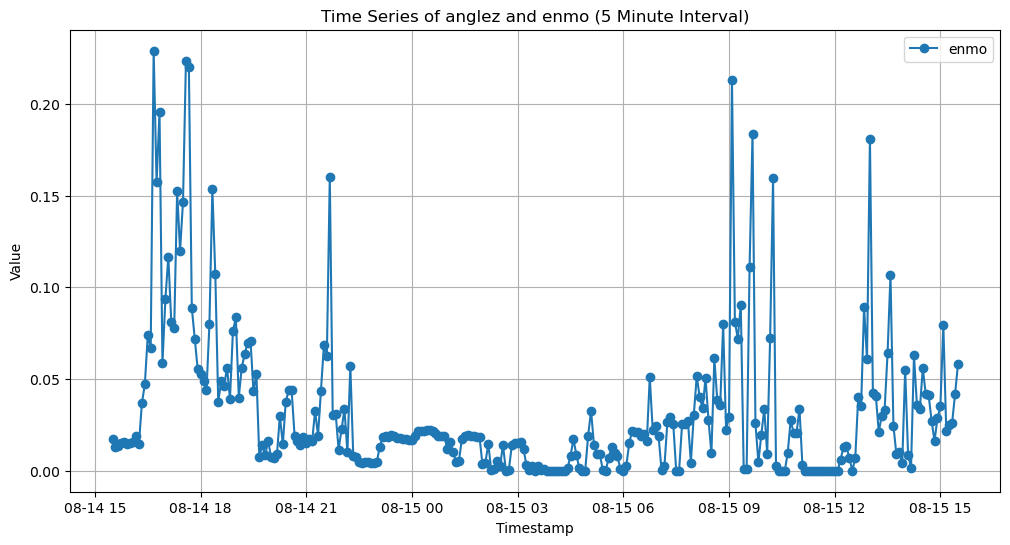

In [33]:
# Assuming you already have a DataFrame named 'filtered_rows' with your data
new_df = filtered_df.loc[0:12*60*24].copy()

# Convert the 'timestamp' column to a datetime format for the new DataFrame
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'])

# Set 'timestamp' as the index for time series plotting
new_df.set_index('timestamp', inplace=True)

# Downsample the data to a half-hour interval and calculate the mean
downsampled_df = new_df.resample('5T').mean(numeric_only = True)

# Plot the downsampled time series of 'anglez' and 'enmo' values
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
#plt.plot(downsampled_df.index, downsampled_df['anglez'], marker='o', linestyle='-', label='anglez')
plt.plot(downsampled_df.index, downsampled_df['enmo'], marker='o', linestyle='-', label='enmo')
plt.title('Time Series of anglez and enmo (5 Minute Interval)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.legend()  # Add a legend to distinguish between 'anglez' and 'enmo'
plt.show()

In [151]:
def generate_point_cloud_embedding(time_series,series_id_num,start_time,end_time,step_size):
    #times_series: Is the series that we are considering
    #series_id_num: Is the series that we are targeting
    #start_time and end_time: Is the start and end time for every day when we want our embedding to start from
    #step_size: is the size that we want to embed for

    # Specify the 'series_id' you want to filter by
    target_series_id = series_id_num

    # Filter rows with the specified 'series_id'
    filtered_time_series = time_series[time_series['series_id'] == target_series_id]

    embedding_for_diff_days = {}
    embedding_for_diff_days_anglez = []
    embedding_for_diff_days_enmo = []
    input_df = filtered_time_series.copy()

    # Assuming your data is in a DataFrame named input_df
    input_df['timestamp'] = pd.to_datetime(input_df["timestamp"])

    # Define the time range for start and end times
    start_time = pd.to_datetime(start_time).time()
    end_time = pd.to_datetime(end_time).time()

    # Filter the rows within the time range for each day
    filtered_time_series_by_date = []
    for date in input_df['timestamp'].dt.date.unique():
        
        #start time for every day
        start = datetime.combine(date,start_time).replace(tzinfo=timezone)
        
        #end time for the next day
        end = datetime.combine(date+timedelta(days=1),end_time).replace(tzinfo=timezone)
        
        day_data = input_df[(input_df['timestamp'] >= start) & (input_df['timestamp'] <= end)]
        
        filtered_time_series_by_date.append(day_data)
    for x in filtered_time_series_by_date[:2]:
        embedding_anglez = []
        embedding_enmo = []
        j = 0
        while j < len(x)-step_size:
            embed_anglez = []
            embed_enmo = []
            for i in range(step_size):
                embed_anglez.append(x["anglez"][j+i])
                embed_enmo.append(x["enmo"][j+i])
            embedding_anglez.append(embed_anglez)
            embedding_enmo.append(embed_enmo)
            j += step_size
        embedding_for_diff_days_anglez.append(embedding_anglez)
        embedding_for_diff_days_enmo.append(embedding_enmo)

    # embeddding_for_diff_days["anglez"] = embedding_for_diff_days_anglez
    # embeddding_for_diff_days["enmo"] = embedding_for_diff_days_enmo
    
        
    return embedding_for_diff_days_anglez

generate_point_cloud_embedding(df,'038441c925bb',"12:00:00","12:00:00",12)[0]

KeyError: 0